In [335]:
 %load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [336]:
%autoreload 2

In [337]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import urllib
from bs4 import BeautifulSoup
import requests
from astropy.io import fits
from astropy.table import Table
import glob
import scipy.integrate
import scipy.stats
import scipy.interpolate
import scipy.optimize
import scipy.signal
import scipy.ndimage
import scipy.spatial
from ProfileClass import PulsarProfile
import seaborn as sns
# import ProfileClass

# Auxilary functions

In [338]:
def is_float(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# ATNF Database

In [339]:
lines = []
with open('psrcat.db') as f:
    lines = f.readlines()
dict_list = []
tmp_dict = {}
for line in lines:
    if len(line,) == 0:
        print("ERROR: Zero length line")
        break
    if line[0] == '@':
        dict_list.append(tmp_dict)
        tmp_dict = {}
    else:
        splitted_line = line.split()
        if(is_float(splitted_line[1])):
            tmp_dict[splitted_line[0]] = float(splitted_line[1])
        else:
            tmp_dict[splitted_line[0]] = splitted_line[1]
data = pd.DataFrame(dict_list)
data.loc[data['F0'].notna(), 'P0'] = 1 / data['F0']
data.loc[data['P0'].notna(), 'F0'] = 1 / data['P0']
data.loc[data['F0'].notna() & data['F1'].notna(), 'P1'] = -data['F1'] / data['F0']**2 
data.loc[data['P0'].notna() & data['P1'].notna(), 'F1'] = -data['P1'] / data['P0']**2

data['B12'] = (data['P0'] * data['P1'] * 1e15)**0.5
data['AGE'] = data['P0'] / data['P1'] / 2
data['Q'] = data['P0']**(5/7) / (data['P1']*1e15)**(2/7)
data['L1400'] = data['S1400'] * data['DIST_DM']**2
data['L'] = 7.4e27 * data['L1400']
data['Edot'] = 3.95 * 1e31 * (data['P1'] / 1e-15)/ data['P0']**3
data['Eff'] = data['L'] / data['Edot']
data = data.set_index('PSRJ')

# Pulsars mean profiles database (.fits)

# FAST profiles

In [340]:
# ----downloading-----
# url = 'http://zmtt.bao.ac.cn/psr-fast/'
# reqs = requests.get(url)
# soup = BeautifulSoup(reqs.text, 'html.parser')
 
# urls = []
# for link in soup.find_all('a'):
#     link_string = link.get('href')
#     if link_string.split('/')[0] == 'whx23dat':
#         print(link_string.split('/')[1])
#         urllib.request.urlretrieve(url+link_string, 'FAST_profiles/' + link_string.split('/')[1])

In [341]:
data.loc['J1827+00'] = pd.Series({'P0': 0.375})
data.loc['J1934+09'] = pd.Series({'P0': 0.0046})
data.loc['J1826-00'] = pd.Series({'P0': 0.0045})
data.loc['J2041+46'] = pd.Series({'P0': 1.159})
data.loc['J1854-01'] = pd.Series({'P0': 0.680})
data.loc['J1849+0340g'] = pd.Series({'P0': 1.666})
data.loc['J1919+04'] = pd.Series({'P0': 0.0039})
data.loc['J1943+28'] = pd.Series({'P0': 0.737})
data.loc['J1944+16'] = pd.Series({'P0': 0.0024})
data.loc['J1852-0054g'] = pd.Series({'P0': 0.164})
data.loc['J1907+0555'] = pd.Series({'P0': 0.168})
data.loc['J1938+14A'] = pd.Series({'P0': 1.661})
data.loc['J1917+24'] = pd.Series({'P0': 0.0043})
data.loc['J1836+09'] = pd.Series({'P0': 0.541})
data.loc['J2021+24'] = pd.Series({'P0': 0.879})
data.loc['J1958+2213'] = pd.Series({'P0': 1.05})
data.loc['J1843+04'] = pd.Series({'P0': 0.397})
data.loc['J1858-02'] = pd.Series({'P0': 1.462})
data.loc['J2025+2133'] = pd.Series({'P0': 0.623})
data.loc['J1929+1905'] = pd.Series({'P0': 0.339})
data.loc['J0625+17'] = pd.Series({'P0': 2.518})
data.loc['J2108+41'] = pd.Series({'P0': 1.511})
data.loc['J1921+1540'] = pd.Series({'P0': 0.143})
data.loc['J2005+38'] = pd.Series({'P0': 2.461})




In [342]:
FASTfiles = glob.glob('FAST_Profiles/*')
FASTnames = []
for file in FASTfiles:
    name = file.split('/')[1]
    name = name.split('I')[0]
    name = name.replace('p', '+')
    name = name.replace('m', '-')
    FASTnames.append(name)
FASTProfiles = pd.DataFrame({'PSRJ': FASTnames, 'FASTfile_name': FASTfiles})
FASTProfiles = FASTProfiles.set_index('PSRJ')
FASTTable = pd.read_csv('KAT?.csv')
FASTTable.set_index('PSRJ', inplace=True)
FASTTable = FASTTable[~FASTTable.index.duplicated(keep='first')]
print(FASTTable)
FASTTable.rename(columns={'W10': 'W10_custom'}, inplace=True) #do not exist in Table!!!
FASTTable.rename(columns={'Mode': 'Mode_FAST'}, inplace=True)
FASTProfiles = FASTProfiles.merge(FASTTable, how='left', left_index=True, right_index=True)
# data = data.merge(FASTProfiles, how='left', left_index=True, right_index=True)

            Mode
PSRJ            
J0011+08      Od
J0848+16     Od?
J1312+1810A   Od
J1538+2345    Od
J1641+3627A   Od
...          ...
J2129+1210A    ?
J2129+4119     ?
J2138+4911     ?
J2208+4056    Os
J2340+08       ?

[195 rows x 1 columns]


In [343]:
Xcount = 0
Ocount = 0
for psr in FASTTable.index:
    if (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xs') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xd'):
        Xcount += 1
    elif (FASTProfiles.loc[psr]['Mode_FAST'] == 'Os') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Od'):
        Ocount += 1
print(Xcount, Ocount, Xcount + Ocount)

63 58 121


## MeerKAT profiles

In [344]:
MeerKATfiles = glob.glob('MeerKAT_Profiles/ar_files/*')
MeerKATnames = []
for file in MeerKATfiles:
    MeerKATnames.append(file.split('/')[2].split('_')[0])
MeerKATProfiles = pd.DataFrame({'PSRJ': MeerKATnames, 'MeerKATfile_name': MeerKATfiles})
MeerKATTable = pd.read_csv('MeerKat.csv')
MeerKATTable.set_index('PSRJ', inplace=True)
MeerKATTable.rename(columns={'W10': 'W10_custom'}, inplace=True)
MeerKATTable.rename(columns={'Mode': 'Mode_MeerKAT'}, inplace=True)

MeerKATProfiles = MeerKATProfiles.set_index('PSRJ')
MeerKATProfiles = MeerKATProfiles.merge(MeerKATTable, how='left', left_index=True, right_index=True)
data = data.merge(MeerKATProfiles, how='left', left_index=True, right_index=True)

In [345]:
MeerKATTable1 = pd.read_csv('Census_Table1.csv')
MeerKATTable1.set_index('PSRJ', inplace=True)
data = pd.concat([MeerKATTable1['P'], data], axis=1)
data.loc[data['P0'].isna(), 'P0'] = data['P']
data = data.drop(columns=['P'])

In [346]:
data.loc['J0514-4407', 'P0']

0.3203

## EPN profiles

In [347]:
EPN_PSR_folders = glob.glob('EPN_ALL/fits/**/*')

In [348]:
EPNnames = []
for folder in EPN_PSR_folders:
    name = folder.split('/')[-1]
    if name[0] == 'B':
        name = data.index[data['PSRB'] == name][0]
    EPNnames.append(name)

# EPN_Profiles = pd.DataFrame({'PSRJ': EPNnames, 'EPNfolder': EPN_PSR_folders})
# EPN_Profiles = EPN_Profiles.set_index('PSRJ')

In [349]:
EPN_Profiles_dict = dict.fromkeys(EPNnames, [])
for i in range(len(EPN_PSR_folders)):
    folder = EPN_PSR_folders[i]
    files = glob.glob(folder+'/*')
    EPN_Profiles_dict[EPNnames[i]] = EPN_Profiles_dict[EPNnames[i]] + files #!!! do not use += 

# Useful subsets

## Fast and MeerKAT subsets

In [350]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()

## FAST orthogonal subset

In [351]:
orthogonal_PSRs_FAST = []
for psr in FASTnames:
    profile = PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    if profile.profile_type == 'orthogonal':
        # plt.plot(np.linspace(0, 1, pulsar_data[0].shape[0]), pulsar_data[0])
        orthogonal_PSRs_FAST.append(psr)
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()
print(np.sort(np.array(orthogonal_PSRs_FAST)))


['J0337+1715' 'J0653+4706' 'J0827+53' 'J1628+4406' 'J1630+3734'
 'J1710+4923' 'J1842+0358' 'J1849+0409' 'J1851+0118' 'J1851+0418'
 'J1852+0056g' 'J1853+1303' 'J1855+0700' 'J1857+0943' 'J1858-0024g'
 'J1909+0749' 'J1913+0832' 'J1913+1050' 'J1918+1541' 'J1921+0137'
 'J1926+0737' 'J1932+1059' 'J1934+2352' 'J1935+1726' 'J1935+2025'
 'J1939+2134' 'J1955+2908' 'J1959+2048' 'J2004+3429' 'J2023+5037'
 'J2032+4127' 'J2047+5029' 'J2053+4650' 'J2208+4056']


In [131]:
tmp = data.loc[orthogonal_PSRs_FAST]
tmp[tmp['P0'] > 0.03]

,RAJ,DECJ,POSEPOCH,PMRA,PMDEC,DM,F0,PEPOCH,F1,PX,...,Q,L1400,L,Edot,Eff,FASTfile_name,Mode_FAST,MeerKATfile_name,Mode_MeerKAT,W10_custom
PSRJ,,,,,,,,,,,,,,,,,,,,,
J1918+1541,19:18:07.70,+15:41:15.2,NaN,NaN,NaN,11.80,2.696268,49079.5,-1.848726e-14,NaN,...,0.377137,NaN,NaN,1.968941e+33,NaN,FAST_Profiles/J1918p1541ILVPA210101.dat,?,MeerKAT_Profiles/ar_files/J1918+1541_2020-07-1...,Xs,5.0
J1926+0737,19:26:33.740,07:37:07.2,NaN,NaN,NaN,159.00,3.144041,54833.6,-3.706872e-15,NaN,...,0.583924,8.368061,6.192365e+28,4.603549e+32,1.345128e-04,FAST_Profiles/J1926p0737ILVPA201226.dat,NaN,MeerKAT_Profiles/ar_files/J1926+0737_2020-05-1...,NaN,NaN
J1909+0749,19:09:08.2,+07:49:32,NaN,NaN,NaN,539.30,4.216540,54870.0,-2.701017e-12,NaN,...,0.085170,15.516662,1.148233e+29,4.498634e+35,2.552404e-07,FAST_Profiles/J1909p0749ILVPA200523.dat,?,MeerKAT_Profiles/ar_files/J1909+0749_2020-05-1...,NaN,NaN
J2047+5029,20:47:54.6400,+50:29:38.17,54250.0,NaN,NaN,107.60,2.242431,54250.0,-2.099760e-14,NaN,...,0.373366,5.995178,4.436432e+28,1.859884e+33,2.385327e-05,FAST_Profiles/J2047p5029ILVPA210327.dat,?,NaN,NaN,NaN
J1842+0358,18:42:17.022,+03:58:35.3,NaN,NaN,NaN,106.70,4.285845,53108.0,-1.490600e-14,NaN,...,0.375373,1.605796,1.188289e+28,2.523450e+33,4.708986e-06,FAST_Profiles/J1842p0358ILVPA220513.dat,NaN,MeerKAT_Profiles/ar_files/J1842+0358_2020-04-0...,Os,3.0
J2032+4127,20:32:13.119,+41:27:24.31,NaN,-2.99,-0.74,114.60,6.980975,55700.0,-5.510000e-13,0.69,...,0.124811,NaN,NaN,1.519374e+35,NaN,FAST_Profiles/J2032p4127ILVPA200402.dat,?,NaN,NaN,NaN
J2004+3429,20:04:46.97,+34:29:17.7,NaN,NaN,NaN,355.00,4.150193,56100.0,-3.562375e-12,NaN,...,0.078872,12.913695,9.556134e+28,5.839895e+35,1.636354e-07,FAST_Profiles/J2004p3429ILVPA200419.dat,NaN,NaN,NaN,NaN
J1855+0700,18:55:17.72,+07:00:37.1,NaN,NaN,NaN,247.20,3.865711,51991.0,-1.123100e-14,NaN,...,0.413039,11.227522,8.308366e+28,1.714924e+33,4.844743e-05,FAST_Profiles/J1855p0700ILVPA201222.dat,Xs?,MeerKAT_Profiles/ar_files/J1855+0700_2020-04-1...,NaN,NaN
J1934+2352,19:34:46.19,+23:52:55.9,NaN,NaN,NaN,355.50,5.604391,54650.0,-4.105151e-12,NaN,...,0.072558,9.234132,6.833258e+28,9.087713e+35,7.519227e-08,FAST_Profiles/J1934p2352ILVPA210609.dat,Os,MeerKAT_Profiles/ar_files/J1934+2352_2020-05-2...,NaN,NaN


In [ ]:
import AuxFunctions as aux

In [ ]:
profile = PulsarProfile(FASTProfiles.loc['J1855+0700']['FASTfile_name'], 'FAST')
profile.plot_profile(plot_fit=True)
print(profile.Ncounts)
print(profile.find_peaks()/profile.Ncounts)
print(aux.noise_estimation(profile.I))
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)

## MeerKAT orthogonal subset

In [408]:
orthogonal_PSRs_MeerKAT = []
for psr in MeerKATnames:
    if not psr in data.index:
        continue
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    if profile.profile_type == 'orthogonal':
        # plt.plot(np.linspace(0, 1, pulsar_data[0].shape[0]), pulsar_data[0])
        orthogonal_PSRs_MeerKAT.append(psr)
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
print(np.sort(np.array(orthogonal_PSRs_MeerKAT)))
orthogonal_PSRs_MeerKAT += ['J1918+1541', 'J1851+0418', 'J1611-5209', 'J1828-1101', 'J0514-4407']


['J0514-4407' 'J0627+0706' 'J0835-3707' 'J0842-4851' 'J0905-5127'
 'J0908-4913' 'J1057-5226' 'J1126-6054' 'J1413-6307' 'J1549-4848'
 'J1637-4553' 'J1705-1906' 'J1722-3712' 'J1739-2903' 'J1755-0903'
 'J1816-0755' 'J1825-0935' 'J1842+0358' 'J1843-0702' 'J1849+0409'
 'J1909+0749' 'J1913+0832' 'J1926+0737' 'J1932+1059' 'J1935+2025']


In [391]:
orthogonal_PSRs_MeerKAT = list(set(orthogonal_PSRs_MeerKAT))

In [ ]:
np.array(orthogonal_PSRs_MeerKAT)

In [ ]:
profile = PulsarProfile(MeerKATProfiles.loc['J1828-1101']['MeerKATfile_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True, plot_pol=False)
print(profile.Ncounts)
print(aux.noise_estimation(profile.I))
print(profile.get_Wa(10))
print(np.array(profile.get_level_bounds(10))/profile.Ncounts)
print(profile.find_peaks()/profile.Ncounts)
print(profile.find_profile_type())

## Fast and MeerKAT manual mode subsets

In [ ]:
MeerKATXs = MeerKATsubset[(MeerKATsubset['Mode_MeerKAT'] == 'Xd') | (MeerKATsubset['Mode_MeerKAT'] == 'Xs')]
MeerKATOs = MeerKATsubset[(MeerKATsubset['Mode_MeerKAT'] == 'Od') | (MeerKATsubset['Mode_MeerKAT'] == 'Os')]
FASTXs = FASTsubset[(FASTsubset['Mode_FAST'] == 'Xd') | (FASTsubset['Mode_FAST'] == 'Xs')]
FASTOs = FASTsubset[(FASTsubset['Mode_FAST'] == 'Od') | (FASTsubset['Mode_FAST'] == 'Os')]

# Profiles processing

# Space for working

## Width statistics: FAST

In [281]:
XW50 = []
OW50 = []
XW10 = []
OW10 = []
Ntrue = 0
Ncomm = 0
Nall = 0
for psr in FASTnames:
    pulsar_profile = PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    # if ((FASTProfiles.loc[psr]['Mode_FAST'] == 'Xs') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xd')) and pulsar_profile.get_mode() == '?':
    #     print(psr)
    # if not (pulsar_profile.find_profile_type() == 'single' or pulsar_profile.find_profile_type() == 'double'):
    #     continue
    if psr in data.index:
        if data.loc[psr]['P0'] < 0.03:
            continue
        if (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xs') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xd'):
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                XW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                XW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        elif (FASTProfiles.loc[psr]['Mode_FAST'] == 'Os') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Od'):
            if pulsar_profile.get_Wa(15) * data.loc[psr]['P0']**0.5 < 60:
                OW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                OW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        mode = pulsar_profile.get_mode()
        # if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 > 60:
        #     print(psr)
        if mode != '?':
            Nall +=1
            if (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xs') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xd'):
                Ncomm += 1
                if mode == 'X':
                    Ntrue += 1
            if (FASTProfiles.loc[psr]['Mode_FAST'] == 'Os') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Od'):
                Ncomm += 1
                if mode == 'O':
                    Ntrue += 1

        # if mode == 'X':
        #     if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 50:
        #         XW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
        #     if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 50:
        #         XW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        # elif mode == 'O':
        #     if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 50:
        #         OW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
        #     if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 50:
        #         OW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        
            

90.984375


'O'

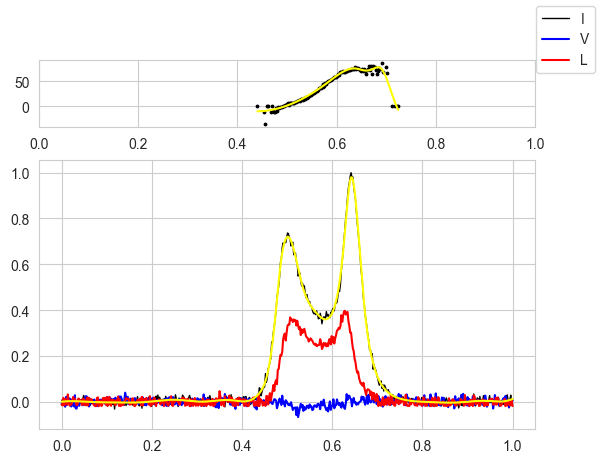

In [177]:
profile = PulsarProfile(FASTProfiles.loc['J2051+4434g']['FASTfile_name'], 'FAST')
print(profile.get_Wa(10) )
profile.plot_profile(plot_fit=True)
profile.get_mode()

In [282]:
print(Nall, Ntrue, Ncomm, Ntrue / Ncomm)
print(len(XW10), len(OW10))

172 72 75 0.96
58 56


In [287]:
XW10 = np.sort(XW10)
OW10 = np.sort(OW10)
print(len(XW10), len(OW10))
NX = len(XW10)
NO = len(OW10)
print(np.median(XW10), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW10[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW10), OW10[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW10[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
# print(scipy.stats.bootstrap((XW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((XW10,), np.median, method='basic'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='basic'))

58 56
12.46373625487331 10.295246434994535 14.787082250118967
15.351219537350595 13.207232161659896 17.890560182216618


KstestResult(statistic=0.2512315270935961, pvalue=0.042950942250736604, statistic_location=11.622524208293001, statistic_sign=1)
TtestResult(statistic=-1.553009000296322, pvalue=0.061621122828238444, df=112.0)
TtestResult(statistic=-1.5541191398753091, pvalue=0.061488675632429865, df=111.9972150539472)
Anderson_ksampResult(statistic=2.4440143470964206, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.03228380723492673)


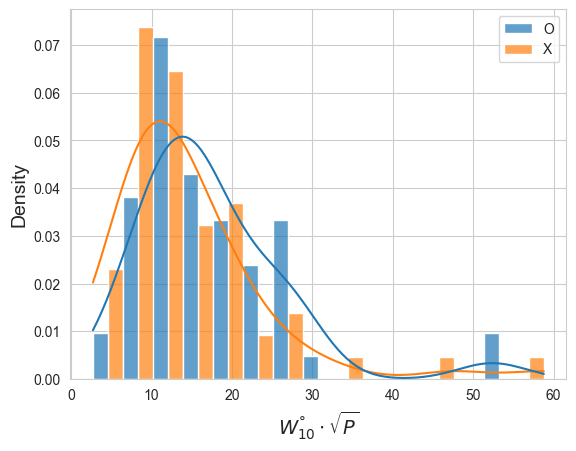

In [285]:
sns.histplot({'O': OW10, 'X':XW10}, kde=True, alpha=0.7, stat='density', palette='tab10', multiple="dodge", common_norm=False)
sns.set_style("whitegrid")
plt.grid(True)
# ax2 = plt.twinx()
# ax2.grid(False)
# sns.ecdfplot({'O': OW10, 'X':XW10}, alpha=0.7, palette='tab10', ax=ax2)
plt.ylabel('Density', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
print(scipy.stats.kstest(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10, alternative='less'))
print(scipy.stats.ttest_ind(XW10, OW10, equal_var=False, alternative='less'))
print(scipy.stats.anderson_ksamp([XW10, OW10]))

# plt.savefig('FAST_mode_comparison_manual.png', dpi=400, bbox_inches='tight')

Text(0.5, 0, '$W_{10}^\\degree \\cdot \\sqrt{P}$')

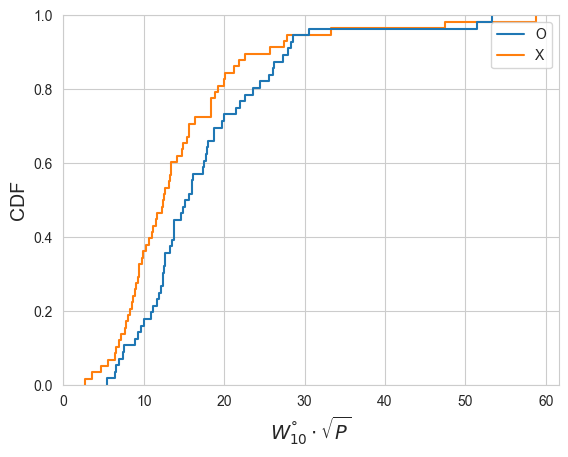

In [199]:
sns.ecdfplot({'O': OW10, 'X':XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('FAST_CDF_manual.png', dpi=400, bbox_inches='tight')

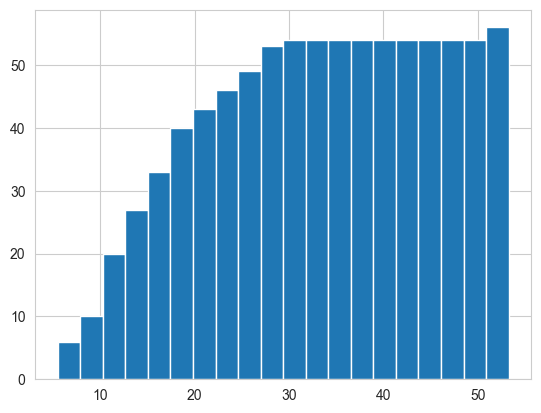

In [292]:
tmp = plt.hist(OW10, cumulative=True, bins=20)
vals = tmp[0]
widths = tmp[1][0:-1]

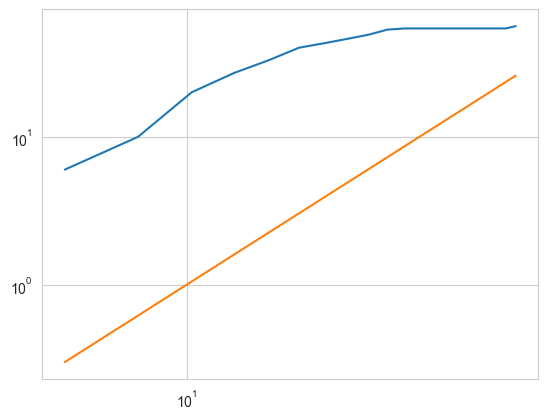

In [295]:
plt.plot(widths, vals)
plt.plot(widths, 0.01 * widths**2)
plt.xscale('log')
plt.yscale('log')

## Width statisticks MeerKAT

In [230]:
XW50 = []
OW50 = []
XW10 = []
OW10 = []
Ntrue = 0
Ncomm = 0
Nall = 0
for psr in MeerKATnames:
    pulsar_profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    # if ((MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Xs') or (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Xd')) and pulsar_profile.get_mode() == '?':
    #     print(psr)
    # if not (pulsar_profile.find_profile_type() == 'single' or pulsar_profile.find_profile_type() == 'double'):
    #     continue
    if psr in data.index:
        if data.loc[psr]['P0'] < 0.03:
            continue
        if (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Xs') or (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Xd'):
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                XW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                XW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        elif (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Os') or (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Od'):
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                OW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                OW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        # mode = pulsar_profile.get_mode()
        # if mode != '?':
        #     Nall += 1
        #     if (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Xs') or (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Xd'):
        #         Ncomm += 1
        #         if mode == 'X':
        #             Ntrue += 1
        #     if (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Os') or (MeerKATProfiles.loc[psr]['Mode_MeerKAT'] == 'Od'):
        #         Ncomm += 1
        #         if mode == 'O':
        #             Ntrue += 1
            # print(psr, mode, MeerKATProfiles.loc[psr]['Mode_MeerKAT'])
        # if mode == 'X':
        #     if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
        #         XW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
        #     if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
        #         XW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        # elif mode == 'O':
        #     if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
        #         OW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
        #     if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
        #         OW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
            

'?'

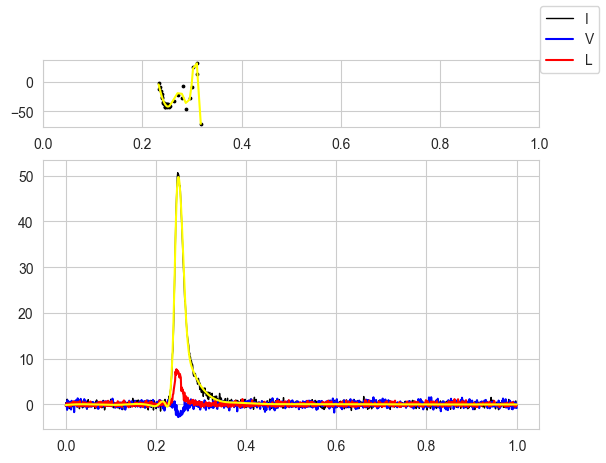

In [189]:
profile = PulsarProfile(MeerKATProfiles.loc['J1653-4249']['MeerKATfile_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True)
profile.get_mode()

In [280]:
# print(Nall, Ntrue, Ncomm, Ntrue / Ncomm)
XW10 = np.sort(XW10)
OW10 = np.sort(OW10)
print(len(XW10), len(OW10))
NX = len(XW10)
NO = len(OW10)
print(np.median(XW10), XW10[int(0.5 * NX - 1.96 * 0.5 * np.sqrt(NX))], XW10[int(0.5 * NX + 1.96 * 0.5 * np.sqrt(NX))])
print(np.median(OW10), OW10[int(0.5 * NO - 1.96 * 0.5 * np.sqrt(NO))], OW10[int(0.5 * NO + 1.96 * 0.5 * np.sqrt(NO))])
print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))
print(scipy.stats.bootstrap((OW10,), np.median, method='basic'))
# print(scipy.stats.bootstrap((OW10,), np.median, method='percentile'))


214 207
10.600441268876846 9.717550789673526 11.66451059817618
15.287278312659243 13.497746574691332 16.14094303799385
BootstrapResult(confidence_interval=ConfidenceInterval(low=13.497746574691332, high=16.14094303799385), bootstrap_distribution=array([15.53789047, 15.5626048 , 15.4623233 , ..., 15.15600661,
       13.37082838, 15.32403437]), standard_error=0.661586643920545)
BootstrapResult(confidence_interval=ConfidenceInterval(low=14.433613587324636, high=17.076810050627152), bootstrap_distribution=array([14.3091005 , 15.14687989, 15.80699503, ..., 15.32403437,
       15.419288  , 15.28908064]), standard_error=0.6643719542904739)


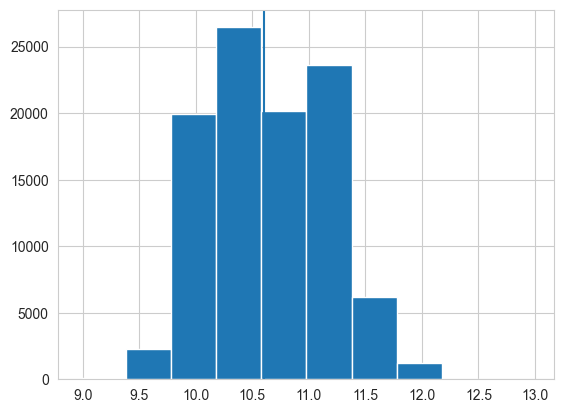

In [275]:
tmp = scipy.stats.bootstrap((XW10,), np.median, method='percentile', n_resamples=100000)
plt.hist(tmp.bootstrap_distribution)
plt.axvline(np.median(XW10))

KstestResult(statistic=0.2512315270935961, pvalue=0.042950942250736604, statistic_location=11.622524208293001, statistic_sign=1)
TtestResult(statistic=-1.553009000296322, pvalue=0.12324224565647689, df=112.0)
TtestResult(statistic=-1.5541191398753091, pvalue=0.12297735126485973, df=111.9972150539472)


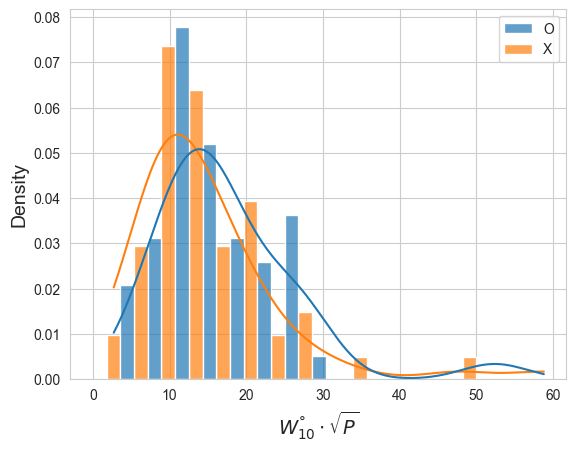

In [334]:
sns.histplot({'O': OW10, 'X':XW10}, kde=True, alpha=0.7, stat='density', palette="tab10", multiple="dodge", binrange=(0, 50), common_norm=False)
plt.ylabel('Density', fontsize=14)
print(scipy.stats.kstest(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10))
print(scipy.stats.ttest_ind(XW10, OW10, equal_var=False))
print(scipy.stats.per)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
plt.savefig('MeerKAT_mode_comparison_manual.png', dpi=400, bbox_inches='tight')

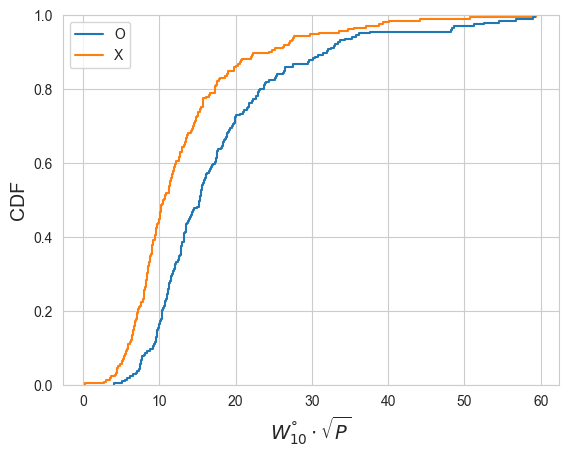

In [162]:
sns.ecdfplot({'O': OW10, 'X':XW10}, palette='tab10')
plt.ylabel('CDF', fontsize=14)
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
# plt.savefig('MeerKAT_CDF_manual.png', dpi=400, bbox_inches='tight')

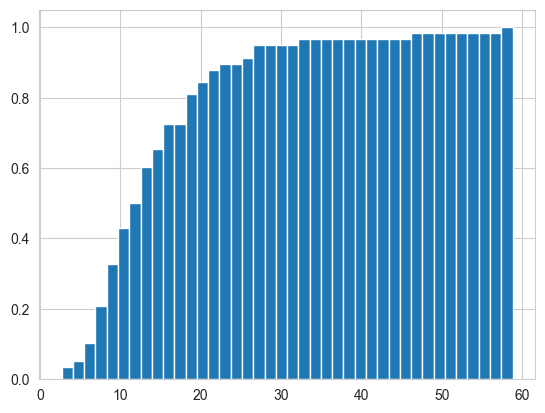

In [313]:
tmp = plt.hist(XW10, cumulative=True, bins=40, density=True)
vals = tmp[0]
widths = tmp[1][0:-1]

[10. 10.]


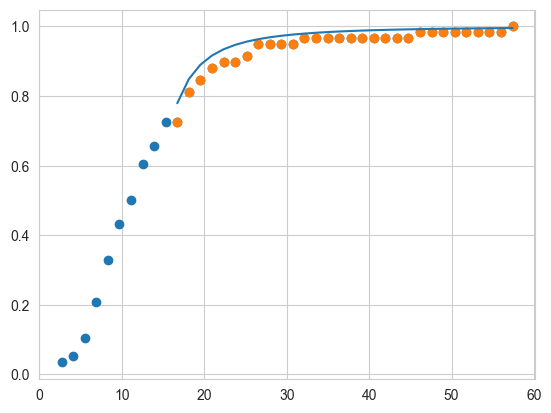

In [333]:
plt.scatter(widths, vals)
plt.scatter(widths[10:], vals[10:])
def fit_func(t, t0, a):
    return 1-a * (t - t0)**(-2)
popt, pcov = scipy.optimize.curve_fit(fit_func, widths[10:], vals[10:], bounds=((0, 0), (10, 10)))
print(popt)
plt.plot(widths[10:], fit_func(widths[10:], *popt))
# plt.plot(widths[8:], 0.5 * widths[8:]**2)
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
profile = PulsarProfile(data.loc['J1921+1419']['FASTfile_name'], 'FAST')
profile.plot_profile(plot_fit=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)


In [ ]:
profile = PulsarProfile(data.loc['J1525-5417']['MeerKATfile_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)



# To plot

In [ ]:
profile_data = read_profile_data(FASTProfiles.loc['J1851+0118']['FASTfile_name'], 'FAST')
print(find_profile_type(profile_data[0]))
# profile_data[0] = scipy.ndimage.gaussian_filter1d(profile_data[0], profile_data[0].shape[0] // 500 + 1, mode='nearest')
phase = np.linspace(-0.5, 0.5, profile_data[0].shape[0])
noise = noise_estimation(profile_data[0])
spl = scipy.interpolate.splrep(phase, profile_data[0], s=profile_data[0].shape[0]*noise**2)
I_func = scipy.interpolate.BSpline(*spl)
plt.plot(phase, profile_data[0])
plt.plot(phase, profile_data[1])
plt.plot(phase, profile_data[2])
plt.plot(phase, I_func(phase))
peaks = find_peaks_number(profile_data[0])
# # print(find_peaks_number(I_func(phase)))
# # peaks, info = scipy.signal.find_peaks(I_func(phase), prominence=np.max(profile_data[0] * 0.05), height=4 * noise)
# print(noise_estimation(profile_data[0])*4)
for peak in peaks:
    plt.axvline(phase[peak], c='r')

## Mean angles estimation

In [ ]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
print(MeerKATsubset[MeerKATsubset['P0'] <= 0.033].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.033) & (MeerKATsubset['P0'] <= 0.5)].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.5) & (MeerKATsubset['P0'] <= 1.0)].shape)
print(MeerKATsubset[MeerKATsubset['P0'] > 1.0].shape)

In [ ]:
MeerKATsubset['CHI'] = np.arcsin(5 * MeerKATsubset['P0']**(-0.5) / MeerKATsubset['W50']) * 180 / np.pi
FASTsubset['CHI'] = np.arcsin(5 * FASTsubset['P0']**(-0.5) / FASTsubset['W50']) * 180 / np.pi


In [ ]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('MeerKAT', size=18)
plt.legend()
plt.savefig('MeerKAT_mean_angles.png', dpi=400)

In [ ]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('FAST', size=18)
plt.legend()
plt.savefig('FAST_mean_angles.png', dpi=400)

## Orthogonals analysis

In [409]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()

In [412]:
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] < 0.03)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.03) & (orthogonalMeerKATs['P0'] < 0.1)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.1) & (orthogonalMeerKATs['P0'] < 0.2)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.2) & (orthogonalMeerKATs['P0'] < 0.3)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.3) & (orthogonalMeerKATs['P0'] < 0.4)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.4) & (orthogonalMeerKATs['P0'] < 0.5)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.5)]))

0
2
7
9
6
1
4


In [413]:
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] < 0.03)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.03) & (orthogonalFASTs['P0'] < 0.1)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.1) & (orthogonalFASTs['P0'] < 0.2)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.2) & (orthogonalFASTs['P0'] < 0.3)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.3) & (orthogonalFASTs['P0'] < 0.4)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.4) & (orthogonalFASTs['P0'] < 0.5)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > 0.5)]))

13
1
5
6
3
2
4


In [431]:
P1 = 0.4
P2 = 0.5
print('MeerKAT')
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]) / (len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)]))*100)
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]))
print((len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)])))
print('FAST')
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]) / (len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))*100)
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]))
print(len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))


MeerKAT
0.8264462809917356
1
121
FAST
3.6363636363636362
2
55


In [ ]:
MeerKATdivs = []
for psr in orthogonal_PSRs_MeerKAT:
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    peaks = profile.find_peaks()
    MeerKATdivs.append(np.min(peaks) / np.max(peaks))


In [ ]:
FASTdivs = []
for psr in orthogonal_PSRs_FAST:
    profile = PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    peaks = profile.find_peaks()
    FASTdivs.append(np.min(peaks) / np.max(peaks))


In [ ]:
print(f'FAST median = {np.median(FASTdivs)}, MeerKAT median = {np.median(MeerKATdivs)}')

In [ ]:
plt.hist(FASTdivs)
plt.hist(MeerKATdivs)

In [ ]:
import DataLoaders

In [ ]:
test_profile = DataLoaders.load_MeerKAT_mean_data(data.loc['J0835-3707']['MeerKATfile_name'])

In [ ]:
# plt.plot(test_profile[0])
fft_vals = scipy.fft.fft(test_profile[0])